# Part 5 : Create an End to End Pipeline

<a id='overview-5'></a>

## [Overview](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 0 : Overview, Architecture and Data Exploration](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 1: Data Prep, Process, Store Features](./1-data-prep-e2e.ipynb)
* [Notebook 2: Train, Check Bias, Tune, Record Lineage, and Register a Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
* [Notebook 3: Mitigate Bias, Train New Model, Store in Registry](./3-mitigate-bias-train-model2-registry-e2e.ipynb)
* [Notebook 4: Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)
* **[Notebook 5 : Create and Run an End-to-End Pipeline to Deploy the Model](./5-pipeline-e2e.ipynb)**
  * **[Architecture](#arch-5)**
  * **[Create an Automated Pipeline](#pipelines)**
  * **[Clean up](#cleanup)**

In this notebook, we will build a SageMaker Pipeline that automates the entire end to end process. Recall that we initially did all the steps in a manual way, and experimented as a data scientist: testing each segment, hands on, and determine for example, which transformations should be applied to the features, which algorithm should be selected, which hyperparamneters, etc.  Now we will automate these steps, and perhaps pass on the responsibility to an ML Engineer or MLOps role.

### Install required and/or update third-party libraries

In [ ]:
!python -m pip install -Uq pip
!python -m pip install -q awswrangler==2.2.0 imbalanced-learn==0.7.0 sagemaker==2.23.1 boto3==1.16.48

### Load stored variables
Run the cell below to load any prevously created variables. You should see a print-out of the existing variables. If you don't see anything you may need to create them again or it may be your first time running this notebook.

In [ ]:
%store -r
%store

**<font color='red'>Important</font>: You must have run the previous sequential notebooks to retrieve variables using the StoreMagic command.**

### Import libraries

In [ ]:
import json
import boto3
import pathlib
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr

import demo_helpers

from sagemaker.xgboost.estimator import XGBoost
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CreateModelStep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.workflow.parameters import ParameterInteger, ParameterFloat, ParameterString

### Set region and boto3 config

In [ ]:
#You can change this to a region of your choice
import sagemaker
region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client('s3', region_name=region)

sagemaker_boto_client = boto_session.client('sagemaker')
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client)
sagemaker_role = sagemaker.get_execution_role()

account_id = boto3.client('sts').get_caller_identity()["Account"]

In [ ]:
#======> Tons of output_paths

training_job_output_path = f's3://{bucket}/{prefix}/training_jobs'
bias_report_output_path = f's3://{bucket}/{prefix}/clarify-bias'
explainability_output_path = f's3://{bucket}/{prefix}/clarify-explainability'

train_data_uri = f's3://{bucket}/{prefix}/data/train/train.csv'
test_data_uri = f's3://{bucket}/{prefix}/data/test/test.csv'
train_data_upsampled_s3_path = f's3://{bucket}/{prefix}/data/train/upsampled/train.csv'
processing_dir = "/opt/ml/processing"
create_dataset_script_uri = f's3://{bucket}/{prefix}/code/create_dataset.py'
pipeline_bias_output_path = f's3://{bucket}/{prefix}/clarify-output/pipeline/bias'
deploy_model_script_uri = f's3://{bucket}/{prefix}/code/deploy_model.py'

#======> variables used for parameterizing the notebook run
flow_instance_count = 1
flow_instance_type = "ml.m5.4xlarge"

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

deploy_model_instance_type = "ml.m4.xlarge"

<a id ='arch-5'> </a>

### Architecture : Create a SageMaker Pipeline to Automate All the Steps from Data Prep to Model Deployment
[overview](#overview-5)

![End to end pipeline architecture](./images/e2e-5-pipeline-v3b.png)

<a id='pipelines'></a>

## SageMaker Pipeline

- [Step 1: Claims Data Wrangler Preprocessing Step](#claims-data-wrangler)
- [Step 2: Customers Data Wrangler Preprocessing step](#data-wrangler)
- [Step 3: Dataset and train test split](#dataset-train-test)
- [Step 4: Train XGboost Model](#pipe-train-xgb)
- [Step 5: Model Pre-deployment](#pipe-pre-deploy)
- [Step 6: Use Clarify to Detect Bias](#pipe-detect-bias)
- [Step 7: Register Model](#pipe-Register-Model)
- [Step 8: Combine the Pipeline Steps and Run](#define-pipeline)


[back to overview](#overview-5)




----
Now that youve manually done each step in our machine learning workflow, you can certain steps to allow for faster model experimentation without sacrificing transparncy and model tracking. In this section you will create a pipeline which trains a new model, persists the model in SageMaker and then adds the model to the registry.

### Pipeline parameters
An important feature of SageMaker Pipelines is the ability to define the steps ahead of time, but be able to change the parameters to those steps at execution without having to re-define the pipeline. This can be achieved by using ParameterInteger, ParameterFloat or ParameterString to define a value upfront which can be modified when you call `pipeline.start(parameters=parameters)` later. Only certain parameters can be defined this way.

In [ ]:
train_instance_param = ParameterString(
    name="TrainingInstance",
    default_value="ml.m4.xlarge",
)

model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="PendingManualApproval"
)

<a id='claims-data-wrangler'></a>

### Step 1: Claims Data Wranger Preprocessing Step
[pipeline](#pipelines)

#### Upload flow to S3
This will become an input to the first step and, as such, needs to be in S3.

In [ ]:
s3_client.upload_file(Filename='claims.flow', Bucket=bucket, Key=f'{prefix}/dataprep-notebooks/claims.flow')
claims_flow_uri = f's3://{bucket}/{prefix}/dataprep-notebooks/claims.flow'
print(f"Claims flow file uploaded to S3")

#### Define the first Data Wrangler step's inputs

In [ ]:
with open('claims.flow', 'r') as f:
    claims_flow = json.load(f)

flow_step_inputs = []

# flow file contains the code for each transformation
flow_file_input = sagemaker.processing.ProcessingInput(
    source=claims_flow_uri,            
    destination=f"{processing_dir}/flow", 
    input_name='flow')

flow_step_inputs.append(flow_file_input)

# parse the flow file for S3 inputs to Data Wranger job
for node in claims_flow["nodes"]:
    if "dataset_definition" in node["parameters"]:
        data_def = node["parameters"]["dataset_definition"]
        name = data_def["name"]
        s3_input = sagemaker.processing.ProcessingInput(
            source=data_def["s3ExecutionContext"]["s3Uri"], 
            destination=f'{processing_dir}/{name}', 
            input_name=name)
        flow_step_inputs.append(s3_input)

#### Define outputs for first Data Wranger step

In [ ]:
claims_output_name = f"{claims_flow['nodes'][-1]['node_id']}.{claims_flow['nodes'][-1]['outputs'][0]['name']}"

flow_step_outputs = []

flow_output = sagemaker.processing.ProcessingOutput(
    output_name=claims_output_name,
    feature_store_output=sagemaker.processing.FeatureStoreOutput(
        feature_group_name=claims_fg_name), 
    app_managed=True)

flow_step_outputs.append(flow_output)

#### Define processor and processing step

In [ ]:
# You can find the proper image uri by exporting your Data Wrangler flow to a pipeline notebook
# =================================
image_uri = "415577184552.dkr.ecr.us-east-2.amazonaws.com/sagemaker-data-wrangler-container:1.0.2"

flow_processor = sagemaker.processing.Processor(
    role=sagemaker_role, 
    image_uri=image_uri, 
    instance_count=flow_instance_count, 
    instance_type=flow_instance_type, 
    max_runtime_in_seconds=86400)

claims_flow_step = ProcessingStep(
    name='ClaimsDataWranglerProcessingStep', 
    processor=flow_processor, 
    inputs=flow_step_inputs, 
    outputs=flow_step_outputs)

<a id='data-wrangler'></a>

### Step 2: Customers Data Wrangler preprocessing step

[pipeline](#pipelines)

In [ ]:
s3_client.upload_file(Filename='customers.flow', Bucket=bucket, Key=f'{prefix}/dataprep-notebooks/customers.flow')
claims_flow_uri = f's3://{bucket}/{prefix}/dataprep-notebooks/customers.flow'
print(f"Customers flow file uploaded to S3")

In [ ]:
with open('customers.flow', 'r') as f:
    customers_flow = json.load(f)
    
flow_step_inputs = []

# flow file contains the code for each transformation
flow_file_input = sagemaker.processing.ProcessingInput(
    source=claims_flow_uri,            
    destination=f"{processing_dir}/flow", 
    input_name='flow')

flow_step_inputs.append(flow_file_input)

# parse the flow file for S3 inputs to Data Wranger job
for node in customers_flow["nodes"]:
    if "dataset_definition" in node["parameters"]:
        data_def = node["parameters"]["dataset_definition"]
        name = data_def["name"]
        s3_input = sagemaker.processing.ProcessingInput(
            source=data_def["s3ExecutionContext"]["s3Uri"], 
            destination=f'{processing_dir}/{name}', 
            input_name=name)
        flow_step_inputs.append(s3_input)

In [ ]:
customers_output_name = f"{customers_flow['nodes'][-1]['node_id']}.{customers_flow['nodes'][-1]['outputs'][0]['name']}"

flow_step_outputs = []

flow_output = sagemaker.processing.ProcessingOutput(
    output_name=customers_output_name,
    feature_store_output=sagemaker.processing.FeatureStoreOutput(
        feature_group_name=customers_fg_name), 
    app_managed=True)

flow_step_outputs.append(flow_output)

customers_flow_step = ProcessingStep(
    name='CustomersDataWranglerProcessingStep', 
    processor=flow_processor, 
    inputs=flow_step_inputs, 
    outputs=flow_step_outputs)

<a id='dataset-train-test'></a>

### Step 3: Create Dataset and Train/Test Split

[pipeline](#pipelines)

In [ ]:
s3_client.upload_file(Filename='create_dataset.py', Bucket=bucket, Key=f'{prefix}/code/create_dataset.py')

create_dataset_processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=sagemaker_role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name='fraud-detection-demo-create-dataset',
    sagemaker_session=sagemaker_session)

create_dataset_step = ProcessingStep(
    name='CreateDataset',
    processor=create_dataset_processor,
    outputs=[sagemaker.processing.ProcessingOutput(output_name='train_data', source='/opt/ml/processing/output/train'),
             sagemaker.processing.ProcessingOutput(output_name='test_data',  source='/opt/ml/processing/output/test')],
    job_arguments=["--claims-feature-group-name", claims_fg_name,
                   "--customers-feature-group-name", customers_fg_name,
                   "--bucket-name", bucket,
                   "--bucket-prefix", prefix,
                   "--athena-database-name", database_name, 
                   "--claims-table-name", claims_table, 
                   "--customers-table-name", customers_table],
    code=create_dataset_script_uri)

<a id='pipe-train-xgb'></a>

### Step 4: Train XGBoost Model
In this step we use the ParameterString `train_instance_param` defined at the beginning of the pipeline.

[pipeline](#pipelines)

In [ ]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.2",
    "objective": "binary:logistic",
    "num_round": "100"
}

xgb_estimator = XGBoost(
    entry_point = "xgboost_starter_script.py",
    output_path = training_job_output_path,
    code_location = training_job_output_path,
    hyperparameters = hyperparameters,
    role = sagemaker_role,
    instance_count = train_instance_count,
    instance_type = train_instance_param,
    framework_version = "1.0-1")

train_step = TrainingStep(
    name='XgboostTrain',
    estimator=xgb_estimator,
    inputs={
        'train': sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs['train_data'].S3Output.S3Uri)}
)

<a id='pipe-pre-deploy'></a>

### Step 5: Model Pre-Deployment Step

[pipeline](#pipelines)

In [ ]:
model = sagemaker.model.Model(
    name='fraud-detection-demo-pipeline-xgboost',
    image_uri=train_step.properties.AlgorithmSpecification.TrainingImage,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=sagemaker_role
)

inputs = sagemaker.inputs.CreateModelInput(
    instance_type="ml.m4.xlarge"
)

create_model_step = CreateModelStep(
    name="ModelPreDeployment",
    model=model,
    inputs=inputs
)

<a id='pipe-detect-bias'></a>

### Step 6: Run Bias Metrics with Clarify
[pipeline](#pipelines)

#### Clarify configuration

In [ ]:
bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=create_dataset_step.properties.ProcessingOutputConfig.Outputs['train_data'].S3Output.S3Uri,
    s3_output_path=pipeline_bias_output_path,
    label='fraud',
    dataset_type='text/csv')

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name='customer_gender_female',
    facet_values_or_threshold=[1])

analysis_config = bias_data_config.get_config()
analysis_config.update(bias_config.get_config())
analysis_config["methods"] = {"pre_training_bias": {"methods": "all"}}

clarify_config_dir = pathlib.Path('config')
clarify_config_dir.mkdir(exist_ok=True)
with open(clarify_config_dir / 'analysis_config.json', 'w') as f:
    json.dump(analysis_config, f)
    
s3_client.upload_file(Filename='config/analysis_config.json', Bucket=bucket, Key=f'{prefix}/clarify-config/analysis_config.json')

#### Clarify processing step

In [ ]:
clarify_processor = sagemaker.processing.Processor(
    base_job_name='fraud-detection-demo-clarify-processor',
    image_uri=sagemaker.clarify.image_uris.retrieve(framework='clarify', region=region),
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.c5.xlarge')

clarify_step = ProcessingStep(
    name="ClarifyProcessor",
    processor=clarify_processor,
    inputs=[
        sagemaker.processing.ProcessingInput(
            input_name="analysis_config",
            source=f's3://{bucket}/{prefix}/clarify-config/analysis_config.json',
            destination="/opt/ml/processing/input/config"),
        sagemaker.processing.ProcessingInput(
            input_name="dataset",
            source=create_dataset_step.properties.ProcessingOutputConfig.Outputs['train_data'].S3Output.S3Uri,
            destination="/opt/ml/processing/input/data")  
    ],
    outputs=[
        sagemaker.processing.ProcessingOutput(
            source="/opt/ml/processing/output/analysis.json",
            destination=pipeline_bias_output_path,
            output_name="analysis_result")
    ]
)

<a id='pipe-Register-Model'></a>
### Step 7: Register Model
In this step you will use the ParameterString `model_approval_status` defined at the outset of the pipeline code.


[pipeline](#pipelines)

In [ ]:
model_metrics = demo_helpers.ModelMetrics(
    bias=sagemaker.model_metrics.MetricsSource(
        s3_uri=clarify_step.properties.ProcessingOutputConfig.Outputs['analysis_result'].S3Output.S3Uri,
        content_type="application/json"
    )
)

register_step = RegisterModel(
    name="XgboostRegisterModel",
    estimator=xgb_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=mpg_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics
)

<a id='pipe-Register-Model'></a>
### Step 8: Deploy Model


[pipeline](#pipelines)

In [ ]:
s3_client.upload_file(Filename='deploy_model.py', Bucket=bucket, Key=f'{prefix}/code/deploy_model.py')

deploy_model_processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=sagemaker_role,
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name='fraud-detection-demo-deploy-model',
    sagemaker_session=sagemaker_session)

deploy_step = ProcessingStep(
    name='DeployModel',
    processor=deploy_model_processor,
    job_arguments=[
        "--model-name", create_model_step.properties.ModelName, 
        "--region", region,
        "--endpoint-instance-type", deploy_model_instance_type,
        "--endpoint-name", "xgboost-model-pipeline-0120"],
    code=deploy_model_script_uri)

<a id='define-pipeline'></a>

### Combine the Pipeline Steps and Run
[pipeline](#overview-5)

Though easier to reason with, the parameters and steps don't need to be in order. The pipeline DAG will parse it out properly.

In [ ]:
pipeline_name = f'FraudDetectDemo'
%store pipeline_name

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        train_instance_param, 
        model_approval_status],
    steps=[
        claims_flow_step,
        customers_flow_step,
        create_dataset_step,
        train_step, 
        create_model_step, 
        clarify_step, 
        register_step,
        deploy_step
    ])

### Submit the pipeline definition to the SageMaker Pipeline service
Note: If an existing pipeline has the same name it will be overwritten.

In [ ]:
pipeline.upsert(role_arn=sagemaker_role)

### View the entire pipeline definition
Viewing the pipeline definition will all the string variables interpolated may help debug pipeline bugs. It is commented out here due to length.

In [ ]:
#json.loads(pipeline.describe()['PipelineDefinition'])

### Run the pipeline
Note this will take about 23 minutes to complete. You can watch the progress of the Pipeline Job on your SageMaker Studio Components panel

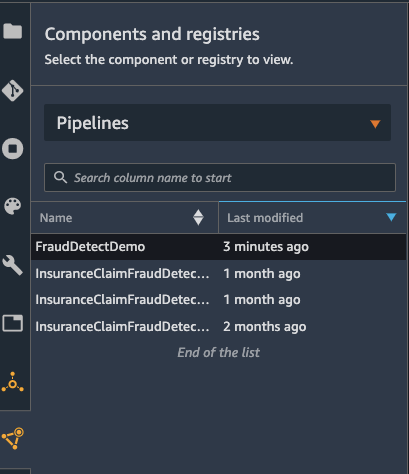

In [ ]:
# Special pipeline parameters can be defined or changed here
parameters = {'TrainingInstance': 'ml.m5.xlarge'}

In [ ]:
start_response = pipeline.start(parameters=parameters)

In [ ]:
start_response.wait()
start_response.describe()

<pre>
</pre>

###after completion it will look something like this
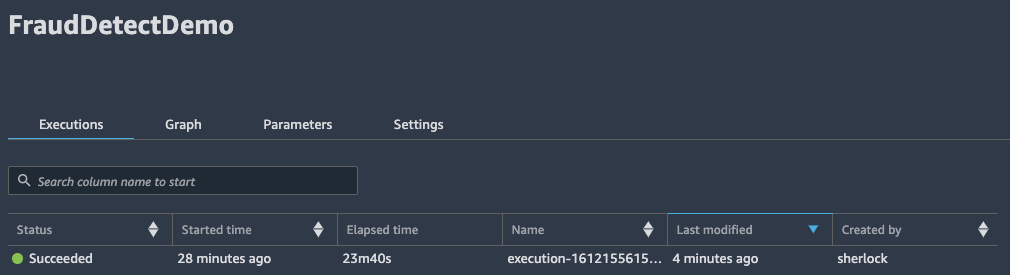

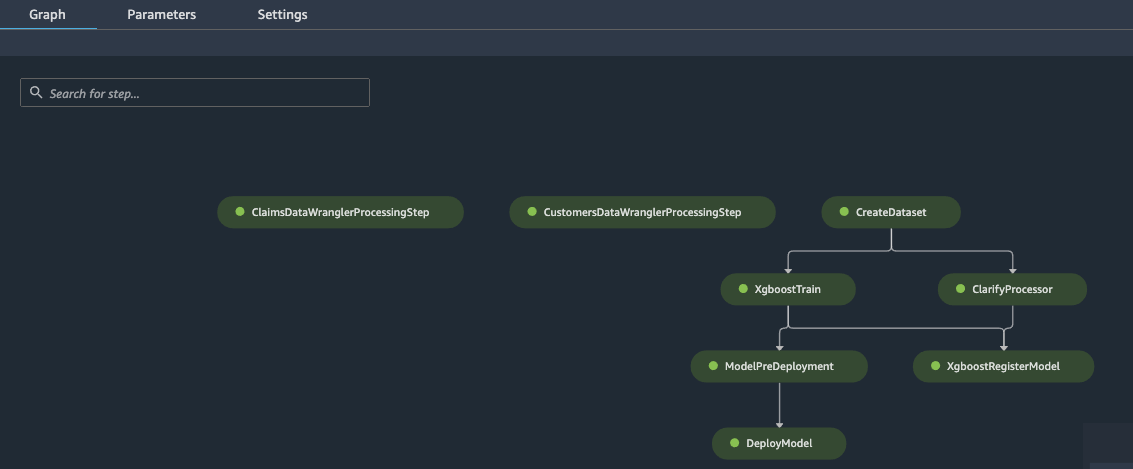

<a id='cleanup'></a>
## Clean up

[overview](#overview-5)
----
After running the demo, you should remove the resources which were created. You can also delete all the objects in the project's S3 directory by passing the keyword argument `delete_s3_objects=True`.

In [ ]:
from demo_helpers import delete_project_resources

In [ ]:
"""
delete_project_resources(
    sagemaker_boto_client=sagemaker_boto_client,
    endpoint_name=endpoint_name, 
    pipeline_name=pipeline_name, 
    mpg_name=mpg_name, 
    prefix=prefix,
    delete_s3_objects=False,
    bucket_name=bucket)
"""